# DAS Data Processing Tutorial for TDMS Files

If running locally, please make sure the following are installed:
 - boto3
 - awscli
 
Additionally, if running in the terminal or command line, be sure to configure awscli with your aws login credentials using:<br>
    $ aws configure
    
After installation, run the following:

In [2]:
import os, sys, logging
import boto3
import numpy as np
import matplotlib.pyplot as plt
import os

from dotenv import load_dotenv
import os

load_dotenv()
# Access the environment variables from the .env file or set them here
aws_access_key_id = os.environ.get('aws_access_key_id')
aws_secret_access_key = os.environ.get('aws_secret_access_key')


boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3',
                    aws_access_key_id=aws_access_key_id, 
                    aws_secret_access_key= aws_secret_access_key)
bucket = s3.Bucket('dfo-test-2')
cwd = os.getcwd()


## Showing info of the data bucket

In [3]:
s3.meta.client.head_bucket(Bucket='dfo-test-2')

{'ResponseMetadata': {'RequestId': 'WF2KS5NK2JE4KADF',
  'HostId': 'sTpKtMFvIiYKk+cj47u6rc+ZNZv/ZWWef4U9cV/a5pNt78fAybGc6Ck+WQtfQM7ShfkFcBb29c8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'sTpKtMFvIiYKk+cj47u6rc+ZNZv/ZWWef4U9cV/a5pNt78fAybGc6Ck+WQtfQM7ShfkFcBb29c8=',
   'x-amz-request-id': 'WF2KS5NK2JE4KADF',
   'date': 'Tue, 19 Sep 2023 22:54:16 GMT',
   'x-amz-bucket-region': 'us-east-1',
   'x-amz-access-point-alias': 'false',
   'content-type': 'application/xml',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

## Total Number of data files in the bucket
This code block shows the total number of objects within the bucket

In [68]:
count = 0
keys = []
for object in bucket.objects.all():
    keys.append(object.key)
    count+=1
    
count
keys

['P10_GL2m_5KHz_Dec1m-4_SM_148GPM_Cover-on_UTC-0600_DST1_20230613_140518.073.tdms',
 'P10_GL2m_5KHz_Dec1m-4_SM_148GPM_Cover-on_UTC-0600_DST1_20230613_140548.073.tdms']

## Accessing the Data
This can be done by either pulling the data directly into the notebook from S3, or by first downloading the data to your computer and then reading it in. Both approaches are shown below.

The files used are key  and only a limited number of them can be download

### Read the Data Directly from bucket
#### Reading in a Few Files

In [71]:
from nptdms import TdmsFile
from shutil import copyfileobj
from urllib.request import urlopen
from tempfile import NamedTemporaryFile
from nptdms import TdmsFile
import pandas as pd

data=pd.DataFrame()
for key in keys:
    tdms_file_path='https://dfo-test-2.s3.us-east-1.amazonaws.com/'+key
    with urlopen(tdms_file_path) as response:
         with NamedTemporaryFile(delete=False) as tmp_file:
            copyfileobj(response, tmp_file)
    from nptdms import TdmsFile

    tdms_file = TdmsFile.read(tmp_file.name)
    if (len(data)==0):
        data=tdms_file['Measurement'].as_dataframe()
        channel_no=data.shape[1]
        time_samples_per_file=data.shape[0]
    else:
        data= data.append(tdms_file['Measurement'].as_dataframe())
        data=data.reset_index(drop=True)
        SamplingFrequency=tdms_file.properties['SamplingFrequency[Hz]']
        SpatialResolution=tdms_file.properties['SpatialResolution[m]']
        StreamTime=tdms_file.properties['StreamTime[s]']
        GaugeLength=tdms_file.properties['GaugeLength']
        GPSTimeStamp=tdms_file.properties['GPSTimeStamp']
        #group = tdms_file['Measurement']   
        #channels_in_group = group.channels()
        #channel = tdms_file['Measurement']['1'][100:200]
        #all_channel_data = channel[:]
        #data_subset = channel[100:200]



[nptdms.tdms_segment WARNING] Data size 672000000 is not a multiple of the chunk size 1048320. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 672000000 is not a multiple of the chunk size 1048320. Will attempt to read last chunk


### Downloading the Data First, and then Reading in the Data
#### Creating the directory structure for storing the DAS data

In [50]:
data_dir = cwd+'/DAS_data'
print(data_dir)
try:
    os.mkdir(data_dir)
    os.mkdir(data_dir+'/DAS')
    os.mkdir(data_dir+'/DAS/TDMS')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)

C:\Users\spmoham\repos\em_das/DAS_data
*Creation of the directory C:\Users\spmoham\repos\em_das/DAS_data failed


#### Downloading Files

##### Download a Subset of the DAS Files

The following code block allows the user to download multiple files from AWS. To download all files, use the commented out code in the block below

In [51]:
for index in np.arange(len(keys)):
    key=keys[index]; 
    file_path = data_dir+'/DAS/TDMS/'+key
    bucket.download_file(key,file_path)
    print(key,'successfully downloaded')


P10_GL2m_5KHz_Dec1m-4_SM_148GPM_Cover-on_UTC-0600_DST1_20230613_140518.073.tdms successfully downloaded
P10_GL2m_5KHz_Dec1m-4_SM_148GPM_Cover-on_UTC-0600_DST1_20230613_140548.073.tdms successfully downloaded


In [10]:
from nptdms import TdmsFile
from shutil import copyfileobj
from urllib.request import urlopen
from tempfile import NamedTemporaryFile
from nptdms import TdmsFile
import pandas as pd

data = pd.DataFrame()
for key in keys:
    tdms_file_path= data_dir+'/DAS/TDMS/'+key
    tdms_file = TdmsFile.read(tdms_file_path)
    if (len(data)==0):
        data=tdms_file['Measurement'].as_dataframe()
        channel_no=data.shape[1]
        time_samples_per_file=data.shape[0]
    else:
        data= data.append(tdms_file['Measurement'].as_dataframe())
        data=data.reset_index(drop=True)

    SamplingFrequency=tdms_file.properties['SamplingFrequency[Hz]']
    SpatialResolution=tdms_file.properties['SpatialResolution[m]']
    StreamTime=tdms_file.properties['StreamTime[s]']
    GaugeLength=tdms_file.properties['GaugeLength']
    GPSTimeStamp=tdms_file.properties['GPSTimeStamp']

    

[nptdms.tdms_segment WARNING] Data size 672000000 is not a multiple of the chunk size 1048320. Will attempt to read last chunk
[nptdms.tdms_segment WARNING] Data size 672000000 is not a multiple of the chunk size 1048320. Will attempt to read last chunk


#### Reading Files for Analysis in Python


## Plotting Raw Data
### Plotting Individual Traces
Individual traces within a stream can be accessed using Stream.taces[trace_index]. In this code block, a subset of the traces are placed into an array and plotted to show change in amplitude over time at different positions along the cable.

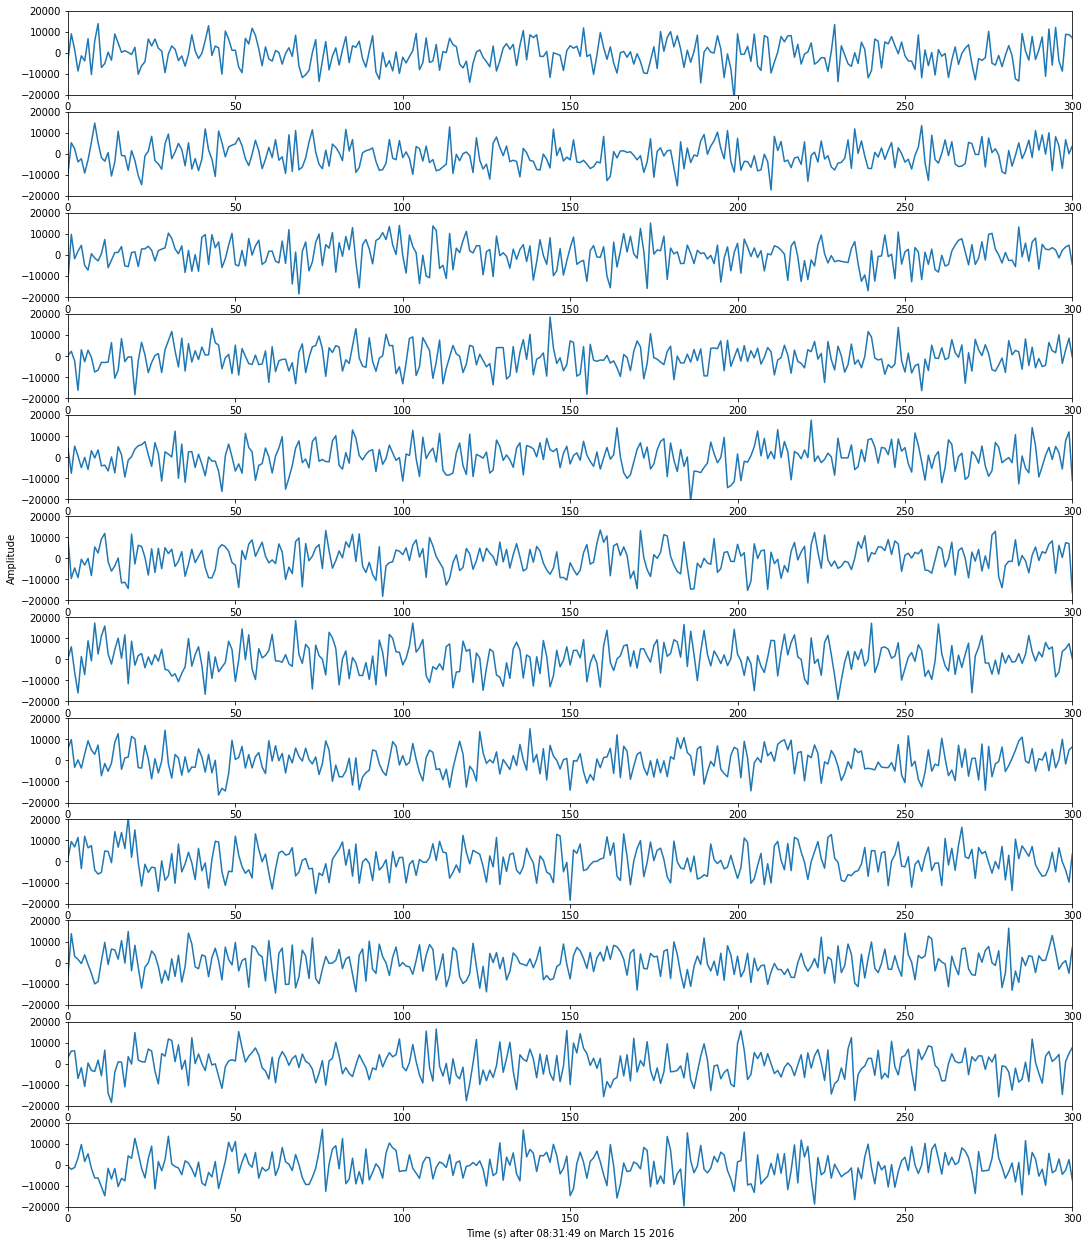

In [52]:
traces = []; trace_no=0
start_trace=40; trace_inc = 15; num_traces = 12
ylim = [-20000,20000]; xlim=[0,300]#xlim=[0,300000]

fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(12,figsize=(18,22))
ax1.plot(data.iloc[:,trace_no].to_numpy()); ax1.set_ylim(ylim); ax1.set_xlim(xlim); trace_no+=1
ax2.plot(data.iloc[:,trace_no].to_numpy()); ax2.set_ylim(ylim); ax2.set_xlim(xlim); trace_no+=1
ax3.plot(data.iloc[:,trace_no].to_numpy()); ax3.set_ylim(ylim); ax3.set_xlim(xlim); trace_no+=1
ax4.plot(data.iloc[:,trace_no].to_numpy()); ax4.set_ylim(ylim); ax4.set_xlim(xlim); trace_no+=1
ax5.plot(data.iloc[:,trace_no].to_numpy()); ax5.set_ylim(ylim); ax5.set_xlim(xlim); trace_no+=1
ax6.plot(data.iloc[:,trace_no].to_numpy()); ax6.set_ylim(ylim); ax6.set_xlim(xlim); trace_no+=1
ax7.plot(data.iloc[:,trace_no].to_numpy()); ax7.set_ylim(ylim); ax7.set_xlim(xlim); trace_no+=1
ax8.plot(data.iloc[:,trace_no].to_numpy()); ax8.set_ylim(ylim); ax8.set_xlim(xlim); trace_no+=1
ax9.plot(data.iloc[:,trace_no].to_numpy()); ax9.set_ylim(ylim); ax9.set_xlim(xlim); trace_no+=1
ax10.plot(data.iloc[:,trace_no].to_numpy()); ax10.set_ylim(ylim); ax10.set_xlim(xlim); trace_no+=1
ax11.plot(data.iloc[:,trace_no].to_numpy()); ax11.set_ylim(ylim); ax11.set_xlim(xlim); trace_no+=1
ax12.plot(data.iloc[:,trace_no].to_numpy()); ax12.set_ylim(ylim); ax12.set_xlim(xlim); trace_no+=1
plt.show()

### Plotting all Traces as an Image
#### Stacking the data for plotting as an image
For plotting using matplotlib's imshow, the trace data (Stream.traces[trace_index].data) must be stacked into a 2D numpy array.

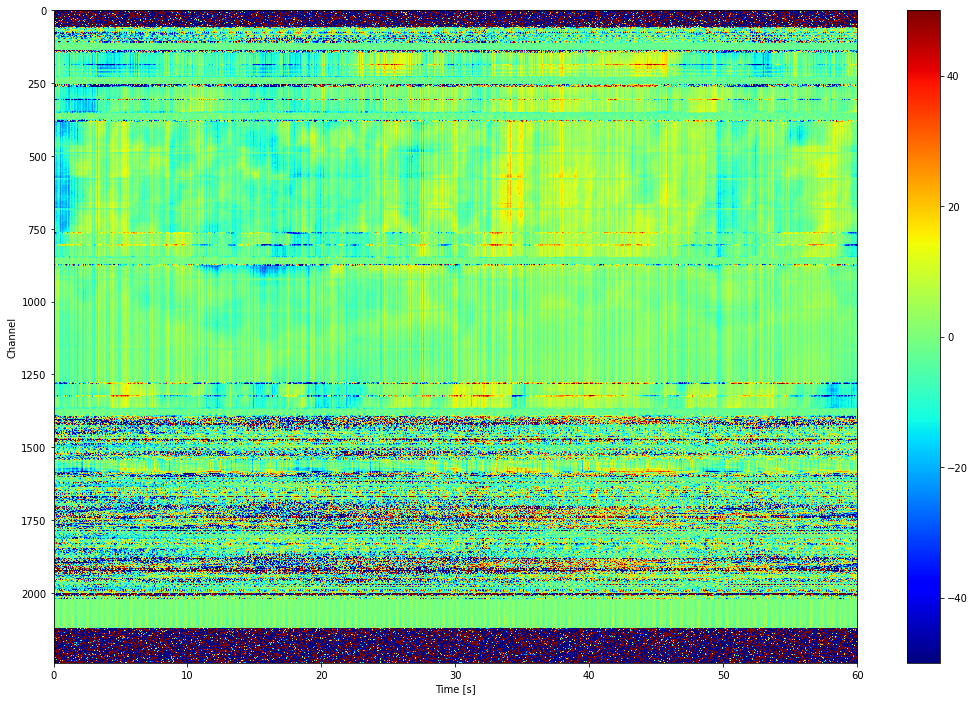

In [75]:
raw_data = data.to_numpy().T
fig, (ax1) = plt.subplots(1,figsize=(18,12))
plot = ax1.imshow(raw_data, cmap="jet", vmin=-50, vmax=50,extent=[0,data.shape[0]/SamplingFrequency,0,data.shape[1]], aspect='auto')
plt.colorbar(plot,ax=ax1)
ax1.invert_yaxis() 
plt.xlabel('Time [s]')
plt.ylabel('Channel')
plt.show()
